# International Football Results Analysis

In [1]:
import pandas as pd
import numpy as np

%config Completer.use_jedi = False

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Optimised read dataset

In [3]:
# df main import code
df = pd.read_csv('results.csv', index_col= 'date')

df['neutral'] = df['neutral'].astype('boolean')

df['home_team'] = df['home_team'].astype('category')
df['away_team'] = df['away_team'].astype('category')

df['tournament'] = df['tournament'].astype('category')

df['country'] = df['country'].astype('category')

df.index = pd.to_datetime(df.index)

In [4]:
df.head(10)

,home_team,away_team,home_score,away_score,tournament,city,country,neutral
date,,,,,,,,
1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-03-08,England,Scotland,4,2,Friendly,London,England,False
1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
1875-03-06,England,Scotland,2,2,Friendly,London,England,False
1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
1876-03-25,Scotland,Wales,4,0,Friendly,Glasgow,Scotland,False
1877-03-03,England,Scotland,1,3,Friendly,London,England,False
1877-03-05,Wales,Scotland,0,2,Friendly,Wrexham,Wales,False
1878-03-02,Scotland,England,7,2,Friendly,Glasgow,Scotland,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41876 entries, 1872-11-30 to 2020-12-09
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   home_team   41876 non-null  category
 1   away_team   41876 non-null  category
 2   home_score  41876 non-null  int64   
 3   away_score  41876 non-null  int64   
 4   tournament  41876 non-null  category
 5   city        41876 non-null  object  
 6   country     41876 non-null  category
 7   neutral     41876 non-null  boolean 
dtypes: boolean(1), category(4), int64(2), object(1)
memory usage: 1.7+ MB


## Q. Who is the best team of all time?

This was analysed on three metrics;

Win Percentage, Points Per Game and Total World Cup Wins.

### Preparing Data

It was identified that the data in the df would have to be transformed to achieve the desired results.

Home and away team columns were looked at to understand the countries/teams that are included in the dataset. 

Both home and away countries were assessed to check whether some countries were listed in one column but not the other. Where this was the case the countries were appended to the homecountrys list which was renamed to countries. 

These would form the index for the gt (Games Table) dataframe, whereby the transformed data would be added to.

In [6]:
df['home_team'].unique()

['Scotland', 'England', 'Wales', 'Northern Ireland', 'United States', ..., 'Timor-Leste', 'Myanmar', 'Parishes of Jersey', 'Chameria', 'Saint Helena']
Length: 308
Categories (308, object): ['Scotland', 'England', 'Wales', 'Northern Ireland', ..., 'Myanmar', 'Parishes of Jersey', 'Chameria', 'Saint Helena']

In [7]:
df['away_team'].unique()

['England', 'Scotland', 'Wales', 'Northern Ireland', 'Canada', ..., 'Barawa', 'Parishes of Jersey', 'Chameria', 'Saint Helena', 'Congo DR']
Length: 306
Categories (306, object): ['England', 'Scotland', 'Wales', 'Northern Ireland', ..., 'Parishes of Jersey', 'Chameria', 'Saint Helena', 'Congo DR']

In [8]:
homecountrys = list(df['home_team'].unique())
homecountrys.sort()
homecountrys

Output = None

In [9]:
awaycountrys = list(df['away_team'].unique())
awaycountrys.sort()
awaycountrys

Output = None

In [10]:
for i in awaycountrys:
    if i not in homecountrys:
        print(i)
        homecountrys.append(i)

Asturias
Congo DR
Surrey
Two Sicilies
Western Australia


In [11]:
countrys = homecountrys

gt stands for games table

MP stands for matches played

W stands for wins

D stands for draws

L stands for losses

GF stands for goals for (goals scored by that team)

GA stands for goals against (goals conceded by that team)

The gt table was used collect the the aggregated country data from the original dataframe.

In [12]:
#gt blank table setup
gt = pd.DataFrame(columns= ['MP','W', 'D', 'L','GF','GA'], index = pd.Index(countrys))
gt.fillna(value = 0, inplace = True)
gt

,MP,W,D,L,GF,GA
Abkhazia,0,0,0,0,0,0
Afghanistan,0,0,0,0,0,0
Albania,0,0,0,0,0,0
Alderney,0,0,0,0,0,0
Algeria,0,0,0,0,0,0
...,...,...,...,...,...,...
Asturias,0,0,0,0,0,0
Congo DR,0,0,0,0,0,0
Surrey,0,0,0,0,0,0
Two Sicilies,0,0,0,0,0,0


The functions below were created to aggregate the data from the original dataset/dataframe into the game table

In [13]:
# Extracts games variables for that row in df

def gamevariables(game):
    home_team = game['home_team']
    away_team = game['away_team']
    home_score = game['home_score']
    away_score = game['away_score']
    return home_team, away_team, home_score, away_score

In [14]:
# Counts the amount of matches that team has played

def gameplayed(table, home_team, away_team):
    table.loc[home_team, 'MP'] += 1
    table.loc[away_team, 'MP'] += 1

In [15]:
# Counts the amount of goals scored and conceeded for that team
# When calling this function for the home and away team just switch the variables around

def teamgoals(table, team1, team1_scored, team2_scored):
    table.loc[team1, 'GF'] += team1_scored
    table.loc[team1, 'GA'] += team2_scored

In [16]:
# Identifies the result of the match between the two teams

def result(table, hometeam, home_score, awayteam, away_score):
    if home_score > away_score:
        table.loc[hometeam, 'W'] += 1
        table.loc[awayteam, 'L'] += 1
    if home_score < away_score:
        table.loc[hometeam, 'L'] += 1
        table.loc[awayteam, 'W'] += 1
    if home_score == away_score:
        table.loc[hometeam, 'D'] += 1
        table.loc[awayteam, 'D'] += 1

A single row was extracted from the df to test that the functions and tables worked as planned

In [17]:
game = df.iloc[1]
game

home_team      England
away_team     Scotland
home_score           4
away_score           2
tournament    Friendly
city            London
country        England
neutral          False
Name: 1873-03-08 00:00:00, dtype: object

In [18]:
table = gt.loc[['Scotland','England']]
table

,MP,W,D,L,GF,GA
Scotland,0,0,0,0,0,0
England,0,0,0,0,0,0


In [19]:
home_team, away_team, home_score, away_score = gamevariables(game)
gameplayed(table, home_team, away_team)
#home team goals
teamgoals(table, home_team, home_score, away_score)
#away team goals
teamgoals(table, away_team, away_score, home_score)
result(table, home_team, home_score, away_team, away_score)
table

,MP,W,D,L,GF,GA
Scotland,1,0,0,1,2,4
England,1,1,0,0,4,2


Once it was established these formulas worked they were applied to the whole of the df

In [20]:
#gt blank table setup
gt = pd.DataFrame(columns= ['MP','W', 'D', 'L','GF','GA'], index = pd.Index(countrys))
gt.fillna(value = 0, inplace = True)
gt

,MP,W,D,L,GF,GA
Abkhazia,0,0,0,0,0,0
Afghanistan,0,0,0,0,0,0
Albania,0,0,0,0,0,0
Alderney,0,0,0,0,0,0
Algeria,0,0,0,0,0,0
...,...,...,...,...,...,...
Asturias,0,0,0,0,0,0
Congo DR,0,0,0,0,0,0
Surrey,0,0,0,0,0,0
Two Sicilies,0,0,0,0,0,0


In [21]:
for i in range(len(df.index)):
    game = df.iloc[i]
    home_team, away_team, home_score, away_score = gamevariables(game)

    gameplayed(gt, home_team, away_team)
    #home team goals
    teamgoals(gt, home_team, home_score, away_score)
    #away team goals
    teamgoals(gt, away_team, away_score, home_score)
    result(gt, home_team, home_score, away_team, away_score)

In [22]:
gt.sort_index()

,MP,W,D,L,GF,GA
Abkhazia,28,12,12,4,48,24
Afghanistan,111,30,24,57,114,223
Albania,339,88,71,180,315,529
Alderney,19,3,0,16,15,75
Algeria,507,215,140,152,710,523
...,...,...,...,...,...,...
Yugoslavia,481,223,98,160,940,740
Zambia,721,330,190,201,1125,740
Zanzibar,205,41,41,123,187,434
Zimbabwe,457,189,126,142,625,519


In [23]:
gt.to_csv('InternationalLeagueTable.csv')

ilt stands for International League Table

In [24]:
ilt = pd.read_csv('InternationalLeagueTable.csv', index_col=0)

In [25]:
ilt.sort_values('MP', ascending = False).head(10)

,MP,W,D,L,GF,GA
Sweden,1027,503,225,299,2025,1321
England,1017,577,243,197,2221,998
Brazil,985,629,199,157,2161,895
Argentina,984,529,244,211,1836,1028
Germany,958,558,198,202,2139,1115
Hungary,938,439,205,294,1905,1399
Uruguay,888,384,216,288,1398,1118
Mexico,873,442,201,230,1522,939
South Korea,864,455,222,187,1516,781
France,848,423,179,246,1512,1108


In [26]:
# GD = Goal Difference 
ilt['GD'] = ilt['GF'] - ilt['GA']
ilt

,MP,W,D,L,GF,GA,GD
Abkhazia,28,12,12,4,48,24,24
Afghanistan,111,30,24,57,114,223,-109
Albania,339,88,71,180,315,529,-214
Alderney,19,3,0,16,15,75,-60
Algeria,507,215,140,152,710,523,187
...,...,...,...,...,...,...,...
Asturias,1,1,0,0,3,1,2
Congo DR,2,0,1,1,1,4,-3
Surrey,1,1,0,0,3,1,2
Two Sicilies,4,1,0,3,2,8,-6


### Win Percentage

In [27]:
# WP = Win Percentage
ilt['WP'] = (ilt['W']/ilt['MP']) * 100

In [28]:
mask = ilt['MP'] >= 100

In [29]:
ilt[mask].sort_values('WP', ascending= False).head(10)

,MP,W,D,L,GF,GA,GD,WP
Brazil,985,629,199,157,2161,895,1266,63.857868
Spain,702,409,162,131,1414,630,784,58.262108
Germany,958,558,198,202,2139,1115,1024,58.246347
England,1017,577,243,197,2221,998,1223,56.735497
Iran,501,274,128,99,929,403,526,54.690619
Czech Republic,305,165,59,81,544,300,244,54.098361
Argentina,984,529,244,211,1836,1028,808,53.760163
Italy,809,428,227,154,1387,782,605,52.904821
New Caledonia,227,120,27,80,614,322,292,52.863436
Croatia,326,172,86,68,569,333,236,52.760736


A. Based on every international game played the best team of all time by win percentage is Brazil.

This result excludes teams that have played less than 100 games.

### Total Points

Total points metric was created to assess which teams had recorded the highest amounts of points of all time.

In [30]:
def totalpoints(country):
    wins = country['W'] * 3
    draws = country['D'] * 1
    totalpoints = wins + draws
    return totalpoints

In [31]:
country = ilt.iloc[0]
country

MP    28.000000
W     12.000000
D     12.000000
L      4.000000
GF    48.000000
GA    24.000000
GD    24.000000
WP    42.857143
Name: Abkhazia, dtype: float64

In [32]:
print(totalpoints(country))

48.0


In [33]:
ilt['TP'] = 0

for i in range(len(ilt.index)):
    country = ilt.iloc[i]
    ilt.iloc[i, -1] = totalpoints(country)

In [34]:
ilt.sort_values('TP', ascending= False)

,MP,W,D,L,GF,GA,GD,WP,TP
Brazil,985,629,199,157,2161,895,1266,63.857868,2086.0
England,1017,577,243,197,2221,998,1223,56.735497,1974.0
Germany,958,558,198,202,2139,1115,1024,58.246347,1872.0
Argentina,984,529,244,211,1836,1028,808,53.760163,1831.0
Sweden,1027,503,225,299,2025,1321,704,48.977605,1734.0
...,...,...,...,...,...,...,...,...,...
Madrid,1,0,0,1,1,2,-1,0.000000,0.0
Manchukuo,3,0,0,3,0,16,-16,0.000000,0.0
Saint Pierre and Miquelon,7,0,0,7,2,78,-76,0.000000,0.0
Sark,4,0,0,4,0,70,-70,0.000000,0.0


###  Points Per Game

Points per game metric was created to negate the effect of one team playing more games than an other and this skewing the total points calculation.

In [35]:
# PPG = points per game
ilt['PPG'] = ilt['TP']/ilt['MP']
ilt

,MP,W,D,L,GF,GA,GD,WP,TP,PPG
Abkhazia,28,12,12,4,48,24,24,42.857143,48.0,1.714286
Afghanistan,111,30,24,57,114,223,-109,27.027027,114.0,1.027027
Albania,339,88,71,180,315,529,-214,25.958702,335.0,0.988201
Alderney,19,3,0,16,15,75,-60,15.789474,9.0,0.473684
Algeria,507,215,140,152,710,523,187,42.406312,785.0,1.548323
...,...,...,...,...,...,...,...,...,...,...
Asturias,1,1,0,0,3,1,2,100.000000,3.0,3.000000
Congo DR,2,0,1,1,1,4,-3,0.000000,1.0,0.500000
Surrey,1,1,0,0,3,1,2,100.000000,3.0,3.000000
Two Sicilies,4,1,0,3,2,8,-6,25.000000,3.0,0.750000


In [36]:
mask = ilt['MP'] >= 100

In [37]:
ilt[mask].sort_values('PPG', ascending = False).head(10)

,MP,W,D,L,GF,GA,GD,WP,TP,PPG
Brazil,985,629,199,157,2161,895,1266,63.857868,2086.0,2.117766
Spain,702,409,162,131,1414,630,784,58.262108,1389.0,1.978632
Germany,958,558,198,202,2139,1115,1024,58.246347,1872.0,1.954071
England,1017,577,243,197,2221,998,1223,56.735497,1974.0,1.941003
Iran,501,274,128,99,929,403,526,54.690619,950.0,1.896208
Italy,809,428,227,154,1387,782,605,52.904821,1511.0,1.867738
Argentina,984,529,244,211,1836,1028,808,53.760163,1831.0,1.860772
Croatia,326,172,86,68,569,333,236,52.760736,602.0,1.846626
South Korea,864,455,222,187,1516,781,735,52.662037,1587.0,1.836806
Czech Republic,305,165,59,81,544,300,244,54.098361,554.0,1.816393


A. Based on points per game metric this ranks Brazil as the best team of all time. 

This excludes teams that have played less than 100 games.

### World Cup Winners

To further add to this analysis, a dataset of World Cup Winners was added to the work book.

Initially it was attempted to obtain this data from the information provided in the original df, however due to different world cup formats, draws at the end of 90 minutes in world cup finals and the lack accompanying penalty data this was difficult to do. 

Alternative data was sourced from - https://en.wikipedia.org/wiki/List_of_FIFA_World_Cup_finals

In [38]:
#data sourced from - https://en.wikipedia.org/wiki/List_of_FIFA_World_Cup_finals

WorldCupWinners = pd.read_csv('WorldCupWinners.csv', index_col = 0,  encoding= 'latin-1', )
WorldCupWinners

,Winners,Score,Runners-up,Venue,Location,Attendance
Year,,,,,,
1930,Uruguay,42,Argentina,Estadio Centenario,"Montevideo, Uruguay","80,000"
1934,Italy,21,Czechoslovakia,Stadio Nazionale PNF,"Rome, Italy","50,000"
1938,Italy,42,Hungary,Stade Olympique de Colombes,"Colombes (Paris), France","45,000"
1950,Uruguay,21,Brazil,Estádio do Maracanã,"Rio de Janeiro, Brazil","199,854"
1954,Germany,32,Hungary,Wankdorf Stadium,"Bern, Switzerland","60,000"
1958,Brazil,52,Sweden,Råsunda Stadium,"Solna (Stockholm), Sweden","51,800"
1962,Brazil,31,Czechoslovakia,Estadio Nacional,"Santiago, Chile","69,000"
1966,England,42,Germany,Wembley Stadium,"London, England","96,924"
1970,Brazil,41,Italy,Estadio Azteca,"Mexico City, Mexico","107,412"


<AxesSubplot:title={'center':'World cup winners sorted by total world cup wins'}, xlabel='Winners', ylabel='Total world cup wins'>

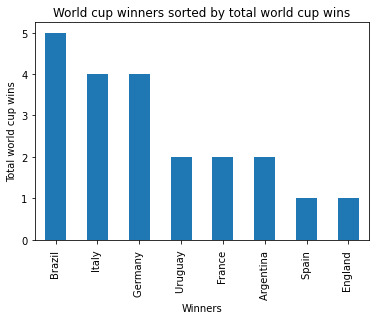

In [39]:
WorldCupWinners.value_counts('Winners').plot(kind = 'bar', title = 'World cup winners sorted by total world cup wins', ylabel = 'Total world cup wins')

A. This data highlights that Brazil have won the most world cups.

### Best team of all time

A. On all metrics assessed, Brazil has the highest win percentage, points per game, and world cup wins.

These finding would indicate that Brazil is the most successful country/team of all time.

## Q. What teams dominated different eras of football?

For this stage of the analysis it was assumed the techniques and workings from above should be applied to the various eras of football. 

Each era was grouped by decade, such as 1870 or 2010 for instance.

In [40]:
df

,home_team,away_team,home_score,away_score,tournament,city,country,neutral
date,,,,,,,,
1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-03-08,England,Scotland,4,2,Friendly,London,England,False
1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
1875-03-06,England,Scotland,2,2,Friendly,London,England,False
1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...
2020-11-18,Greece,Slovenia,0,0,UEFA Nations League,Athens,Greece,False
2020-11-18,Albania,Belarus,3,2,UEFA Nations League,Tirana,Albania,False
2020-11-18,Kazakhstan,Lithuania,1,2,UEFA Nations League,Almaty,Kazakhstan,False


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41876 entries, 1872-11-30 to 2020-12-09
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   home_team   41876 non-null  category
 1   away_team   41876 non-null  category
 2   home_score  41876 non-null  int64   
 3   away_score  41876 non-null  int64   
 4   tournament  41876 non-null  category
 5   city        41876 non-null  object  
 6   country     41876 non-null  category
 7   neutral     41876 non-null  boolean 
dtypes: boolean(1), category(4), int64(2), object(1)
memory usage: 1.7+ MB


gameyear metric was added to allow for games from different decades to be grouped

In [42]:
gameyear = pd.Series(df.index.year)
gameyear

0        1872
1        1873
2        1874
3        1875
4        1876
         ... 
41871    2020
41872    2020
41873    2020
41874    2020
41875    2020
Name: date, Length: 41876, dtype: int64

In [43]:
year = 1886

In [44]:
year = list(str(year))
year[-1] = '0'
year = int(''.join(year))
year


1880

In [45]:
# decadecal stands for decade calculation

def decadecal(year):   
    year = list(str(year))
    year[-1] = '0'
    year = int(''.join(year)) 
    return year

In [46]:
# decaderes stands for decade result

decaderes = gameyear.apply(decadecal)
decaderes.name = 'decade'
decaderes

0        1870
1        1870
2        1870
3        1870
4        1870
         ... 
41871    2020
41872    2020
41873    2020
41874    2020
41875    2020
Name: decade, Length: 41876, dtype: int64

As the series of df and decade do not match you have to add decaderes.values to the inputted series to ensure that you do not return NaN values

https://stackoverflow.com/questions/26221300/nan-values-when-new-column-added-to-pandas-dataframe

In [47]:
df.insert(0, 'decade', decaderes.values)

In [48]:
df

,decade,home_team,away_team,home_score,away_score,tournament,city,country,neutral
date,,,,,,,,,
1872-11-30,1870,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-03-08,1870,England,Scotland,4,2,Friendly,London,England,False
1874-03-07,1870,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
1875-03-06,1870,England,Scotland,2,2,Friendly,London,England,False
1876-03-04,1870,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
2020-11-18,2020,Greece,Slovenia,0,0,UEFA Nations League,Athens,Greece,False
2020-11-18,2020,Albania,Belarus,3,2,UEFA Nations League,Tirana,Albania,False
2020-11-18,2020,Kazakhstan,Lithuania,1,2,UEFA Nations League,Almaty,Kazakhstan,False


In [49]:
eras = df.groupby('decade')

In [50]:
eras.groups.keys()

decadelist = list(eras.groups.keys())
decadelist

[1870,
 1880,
 1890,
 1900,
 1910,
 1920,
 1930,
 1940,
 1950,
 1960,
 1970,
 1980,
 1990,
 2000,
 2010,
 2020]

The code was applied to just the 1870 era to check that it worked with an individual groupby object.

In [51]:
currentera = eras.get_group(1870)
currentera

,decade,home_team,away_team,home_score,away_score,tournament,city,country,neutral
date,,,,,,,,,
1872-11-30,1870,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-03-08,1870,England,Scotland,4,2,Friendly,London,England,False
1874-03-07,1870,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
1875-03-06,1870,England,Scotland,2,2,Friendly,London,England,False
1876-03-04,1870,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
1876-03-25,1870,Scotland,Wales,4,0,Friendly,Glasgow,Scotland,False
1877-03-03,1870,England,Scotland,1,3,Friendly,London,England,False
1877-03-05,1870,Wales,Scotland,0,2,Friendly,Wrexham,Wales,False
1878-03-02,1870,Scotland,England,7,2,Friendly,Glasgow,Scotland,False


In [52]:
#gt blank table setup
gt = pd.DataFrame(columns= ['country','MP','W', 'D', 'L','GF','GA'], index = pd.Index(countrys))
gt.fillna(value = 0, inplace = True)
gt['country'] = gt.index.values
gt

,country,MP,W,D,L,GF,GA
Abkhazia,Abkhazia,0,0,0,0,0,0
Afghanistan,Afghanistan,0,0,0,0,0,0
Albania,Albania,0,0,0,0,0,0
Alderney,Alderney,0,0,0,0,0,0
Algeria,Algeria,0,0,0,0,0,0
...,...,...,...,...,...,...,...
Asturias,Asturias,0,0,0,0,0,0
Congo DR,Congo DR,0,0,0,0,0,0
Surrey,Surrey,0,0,0,0,0,0
Two Sicilies,Two Sicilies,0,0,0,0,0,0


In [53]:
for i in range(len(currentera.index)):
    game = currentera.iloc[i]
    home_team, away_team, home_score, away_score = gamevariables(game)

    gameplayed(gt, home_team, away_team)
    #home team goals
    teamgoals(gt, home_team, home_score, away_score)
    #away team goals
    teamgoals(gt, away_team, away_score, home_score)
    result(gt, home_team, home_score, away_team, away_score)

In [54]:
gt

,country,MP,W,D,L,GF,GA
Abkhazia,Abkhazia,0,0,0,0,0,0
Afghanistan,Afghanistan,0,0,0,0,0,0
Albania,Albania,0,0,0,0,0,0
Alderney,Alderney,0,0,0,0,0,0
Algeria,Algeria,0,0,0,0,0,0
...,...,...,...,...,...,...,...
Asturias,Asturias,0,0,0,0,0,0
Congo DR,Congo DR,0,0,0,0,0,0
Surrey,Surrey,0,0,0,0,0,0
Two Sicilies,Two Sicilies,0,0,0,0,0,0


In [55]:
gt['GD'] = gt['GF'] - gt['GA']

In [56]:
mask = gt['MP'] > 0
gt = gt[mask]
gt

,country,MP,W,D,L,GF,GA,GD
England,England,9,3,2,4,17,24,-7
Scotland,Scotland,12,8,2,2,41,15,26
Wales,Wales,5,0,0,5,1,20,-19


In [57]:
gt.sort_values('MP', ascending = False)

,country,MP,W,D,L,GF,GA,GD
Scotland,Scotland,12,8,2,2,41,15,26
England,England,9,3,2,4,17,24,-7
Wales,Wales,5,0,0,5,1,20,-19


In [58]:
# WP = Win Percentage
gt['WP'] = (gt['W']/gt['MP']) * 100

gt

<ipython-input-58-7108048eb286>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt['WP'] = (gt['W']/gt['MP']) * 100


,country,MP,W,D,L,GF,GA,GD,WP
England,England,9,3,2,4,17,24,-7,33.333333
Scotland,Scotland,12,8,2,2,41,15,26,66.666667
Wales,Wales,5,0,0,5,1,20,-19,0.000000


In [59]:
gt['TP'] = 0

for i in range(len(gt.index)):
    country = gt.iloc[i]
    gt.iloc[i, -1] = totalpoints(country)
    
gt

<ipython-input-59-acc9edae41f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt['TP'] = 0
C:\Users\Adam\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,country,MP,W,D,L,GF,GA,GD,WP,TP
England,England,9,3,2,4,17,24,-7,33.333333,11
Scotland,Scotland,12,8,2,2,41,15,26,66.666667,26
Wales,Wales,5,0,0,5,1,20,-19,0.000000,0


In [60]:
# PPG = points per game
gt['PPG'] = gt['TP']/gt['MP']
gt

<ipython-input-60-ff7051f833b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt['PPG'] = gt['TP']/gt['MP']


,country,MP,W,D,L,GF,GA,GD,WP,TP,PPG
England,England,9,3,2,4,17,24,-7,33.333333,11,1.222222
Scotland,Scotland,12,8,2,2,41,15,26,66.666667,26,2.166667
Wales,Wales,5,0,0,5,1,20,-19,0.000000,0,0.000000


In [61]:
highperform = gt.sort_values('PPG', ascending = False).head(1)
highperform

,country,MP,W,D,L,GF,GA,GD,WP,TP,PPG
Scotland,Scotland,12,8,2,2,41,15,26,66.666667,26,2.166667


In [62]:
sampledecade = [1870]

The eratable below is based off the same format of the gt table. This is used as the data structure to add all the teams that have the highest points per game metric from each era into. 

In the first instance this was created only with an index for the sampledecade.

In [63]:
eratable = pd.DataFrame(columns= ['country','MP','W', 'D', 'L','GF','GA', 'WP', 'TP', 'PPG'], index = pd.Index(sampledecade))
eratable.fillna(value = 0, inplace = True)

In [64]:
eratable

,country,MP,W,D,L,GF,GA,WP,TP,PPG
1870,0,0,0,0,0,0,0,0,0,0


In [65]:
cdata = highperform.iloc[0]
cdata

country    Scotland
MP               12
W                 8
D                 2
L                 2
GF               41
GA               15
GD               26
WP          66.6667
TP               26
PPG         2.16667
Name: Scotland, dtype: object

In [66]:
eratable.loc[sampledecade[0]] = cdata

In [67]:
eratable

,country,MP,W,D,L,GF,GA,WP,TP,PPG
1870,Scotland,12,8,2,2,41,15,66.666667,26,2.166667


Once it was established that this code could work for one era this was applied across all grouped eras in the groupby object.

In [68]:
eras.groups.keys()

decadelist = list(eras.groups.keys())
decadelist

[1870,
 1880,
 1890,
 1900,
 1910,
 1920,
 1930,
 1940,
 1950,
 1960,
 1970,
 1980,
 1990,
 2000,
 2010,
 2020]

In [69]:
import os
from pathlib import Path

In [70]:
os.makedirs('./eras', exist_ok=True)

This code below is the principles above applied to all decades (dec) in the eras groupby object. These aggregated tables were exported to csv files.

In [71]:
for dec in decadelist:
    currentera = eras.get_group(dec)

    gt = pd.DataFrame(columns= ['country','MP','W', 'D', 'L','GF','GA'], index = pd.Index(countrys))
    gt.fillna(value = 0, inplace = True)
    
    for i in range(len(currentera.index)):
        game = currentera.iloc[i]
        home_team, away_team, home_score, away_score = gamevariables(game)

        gameplayed(gt, home_team, away_team)
        #home team goals
        teamgoals(gt, home_team, home_score, away_score)
        #away team goals
        teamgoals(gt, away_team, away_score, home_score)
        result(gt, home_team, home_score, away_team, away_score)
        
    gt['GD'] = gt['GF'] - gt['GA']

    # WP = Win Percentage
    gt['WP'] = (gt['W']/gt['MP']) * 100

    gt['TP'] = 0

    for k in range(len(gt.index)):
        country = gt.iloc[k]
        gt.iloc[k, -1] = totalpoints(country)

    #PPG = points per game
    gt['PPG'] = gt['TP']/gt['MP']

    gt['country'] = gt.index.values
            
    gt.to_csv('./eras/' + str(dec) +'.csv')
    
    print(str(dec) + ' era saved as csv')

1870 era saved as csv
1880 era saved as csv
1890 era saved as csv
1900 era saved as csv
1910 era saved as csv
1920 era saved as csv
1930 era saved as csv
1940 era saved as csv
1950 era saved as csv
1960 era saved as csv
1970 era saved as csv
1980 era saved as csv
1990 era saved as csv
2000 era saved as csv
2010 era saved as csv
2020 era saved as csv


The eratable below was expanded to included an index for the all the different eras in the data set by editing the dataframe index.

In [72]:
eratable = pd.DataFrame(columns= ['country','MP','W', 'D', 'L','GF','GA', 'WP', 'TP', 'PPG'], index = pd.Index(decadelist))
eratable.fillna(value = 0, inplace = True)
eratable

,country,MP,W,D,L,GF,GA,WP,TP,PPG
1870,0,0,0,0,0,0,0,0,0,0
1880,0,0,0,0,0,0,0,0,0,0
1890,0,0,0,0,0,0,0,0,0,0
1900,0,0,0,0,0,0,0,0,0,0
1910,0,0,0,0,0,0,0,0,0,0
1920,0,0,0,0,0,0,0,0,0,0
1930,0,0,0,0,0,0,0,0,0,0
1940,0,0,0,0,0,0,0,0,0,0
1950,0,0,0,0,0,0,0,0,0,0
1960,0,0,0,0,0,0,0,0,0,0


In [73]:
for file in os.listdir('./eras'):
    link = Path('./eras', file)
    gt = pd.read_csv(link, index_col = 0)
    p = Path(file)
    dec = p.stem

The decade csv files were read and filtered on the matches played mean value to ensure only teams which had played more than this value were included. This was to remove teams which had high points per game metrics because they had only played a small amount of games.

This filtered dataframe was then sorted based on points per game and then the team with the highest values were extracted and added to the eratable.

In [74]:
for file in os.listdir('./eras'):
    link = Path('./eras', file)
    gt = pd.read_csv(link, index_col = 0)
    p = Path(file)
    dec = int(p.stem)
    
    mask = gt['MP'] > 0
    gt = gt[mask]

    medianMP = gt['MP'].mean()

    mask1 = gt['MP'] > medianMP
    gt = gt[mask1]
    
    # metric for returning the first value of the data set
    gt.sort_values(['PPG','TP','MP','W','GD'], ascending = False, inplace = True)
    
    cdata = gt.iloc[0]

    eratable.loc[dec] = cdata      

In [75]:
eratable

,country,MP,W,D,L,GF,GA,WP,TP,PPG
1870,Scotland,12,8,2,2,41,15,66.666667,26.0,2.166667
1880,Scotland,27,23,3,1,114,32,85.185185,72.0,2.666667
1890,England,30,24,4,2,123,27,80.000000,76.0,2.533333
1900,England,37,25,9,3,113,31,67.567568,84.0,2.270270
1910,Denmark,24,19,1,4,90,24,79.166667,58.0,2.416667
1920,Spain,22,17,3,2,59,16,77.272727,54.0,2.454545
1930,Italy,67,45,13,9,156,78,67.164179,148.0,2.208955
1940,Argentina,59,43,9,7,191,75,72.881356,138.0,2.338983
1950,Hungary,88,60,15,13,300,116,68.181818,195.0,2.215909
1960,Ghana,70,46,18,6,218,74,65.714286,156.0,2.228571


In [76]:
eratable.to_csv('EraDominance.csv')

A.  The table above highlights the various teams that dominated the different eras of football based on their points per game rating. 

Other techniques could have been applied to improve the quality of the analysis.

One metric that could be used would be to give a higher weighting for positive results against higher standard opponents compared to that of lower standard opponents. For the current data used with the existing techniques applied, a win against the world’s best is given an equal rating to that of a win against low standard teams. This is not overly conducive for accurate analysis.

Another alternative would be to give results from the various game types/tournaments different weightings based on their importance. For instance, World Cup games could be rated the highest and friendly games the lowest.

Applying these alternative techniques could have allowed for a more accurate rating for each team for each era, based on the opposition played and their performance in key games.

## Q. Has there been any trends for home advantage in international football throughout the ages?

In [77]:
df

,decade,home_team,away_team,home_score,away_score,tournament,city,country,neutral
date,,,,,,,,,
1872-11-30,1870,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-03-08,1870,England,Scotland,4,2,Friendly,London,England,False
1874-03-07,1870,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
1875-03-06,1870,England,Scotland,2,2,Friendly,London,England,False
1876-03-04,1870,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
2020-11-18,2020,Greece,Slovenia,0,0,UEFA Nations League,Athens,Greece,False
2020-11-18,2020,Albania,Belarus,3,2,UEFA Nations League,Tirana,Albania,False
2020-11-18,2020,Kazakhstan,Lithuania,1,2,UEFA Nations League,Almaty,Kazakhstan,False


Dataframe was filtered to only include games that were played at non neutral venues.

In [78]:
mask = df['neutral'] == False

In [79]:
nonneutral = df[mask]
nonneutral

,decade,home_team,away_team,home_score,away_score,tournament,city,country,neutral
date,,,,,,,,,
1872-11-30,1870,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-03-08,1870,England,Scotland,4,2,Friendly,London,England,False
1874-03-07,1870,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
1875-03-06,1870,England,Scotland,2,2,Friendly,London,England,False
1876-03-04,1870,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
2020-11-18,2020,Greece,Slovenia,0,0,UEFA Nations League,Athens,Greece,False
2020-11-18,2020,Albania,Belarus,3,2,UEFA Nations League,Tirana,Albania,False
2020-11-18,2020,Kazakhstan,Lithuania,1,2,UEFA Nations League,Almaty,Kazakhstan,False


In [80]:
totalmatches = len(nonneutral)
totalmatches

31557

Trial game was extracted to check if the code for assessing and counting the results of the games worked.

In [81]:
game = nonneutral.iloc[1]
game

decade            1870
home_team      England
away_team     Scotland
home_score           4
away_score           2
tournament    Friendly
city            London
country        England
neutral          False
Name: 1873-03-08 00:00:00, dtype: object

In [82]:
homewins = 0
awaywins = 0
draws = 0

In [83]:
home_team, away_team, home_score, away_score = gamevariables(game)
    
if home_score > away_score:
    homewins += 1
elif home_score < away_score:
    awaywins += 1
else:
    draws += 1  

In [84]:
homewins

1

Once it was established that this coding technique would work this was applied to whole dataframe

In [85]:
homewins = 0
awaywins = 0
draws = 0

for i in range(len(nonneutral)):
    game = nonneutral.iloc[i]
    
    home_team, away_team, home_score, away_score = gamevariables(game)
    
    if home_score > away_score:
        homewins += 1
    elif home_score < away_score:
        awaywins += 1
    else:
        draws += 1

In [86]:
homewins

15915

In [87]:
awaywins

8341

In [88]:
draws

7301

In [89]:
homewins + awaywins + draws

31557

In [90]:
totalmatches == homewins + awaywins + draws

True

In [91]:
homewins/awaywins

1.9080445989689485

In [92]:
homewins/draws

2.179838378304342

The calculations above suggest that for any random matched pick from the dataset that is held at a non neutral ground it is almost two times more likely to be a home win compared to that of a draw of away win.

The percentages below show the match result as a percentage of total games for the whole dataset.

In [93]:
# Total Matches Home Win Percentage
TMHWPer = (homewins/totalmatches)*100
TMHWPer

50.43255062268276

In [94]:
# Total Matches Away Win Percentage
TMAWPer = (awaywins/totalmatches)*100
TMAWPer

26.43153658459296

In [95]:
# Total Matches Draw Percentage
TMDPer = (draws/totalmatches)*100
TMDPer

23.135912792724277

In [96]:
TMHWPer + TMAWPer + TMDPer

100.0

The eras groupby object was created earlier on in this notebook. Code was then applied to the individual eras contained in the groupby object.

In [97]:
eras

In [98]:
eras.groups.keys()

decadelist = list(eras.groups.keys())
decadelist

[1870,
 1880,
 1890,
 1900,
 1910,
 1920,
 1930,
 1940,
 1950,
 1960,
 1970,
 1980,
 1990,
 2000,
 2010,
 2020]

eraHA stands for era home advantage. The eraHA dataframe is designed to capture all the matches results from the different eras

TM stands for Total Matches

HW stands for Home Wins

AW stands for Away Wins

D stands for Draws 

In [99]:
eraHA= pd.DataFrame(columns= ['TM','HW','AW','D'], index = pd.Index(decadelist))
eraHA.fillna(value= 0, inplace = True)
eraHA

,TM,HW,AW,D
1870,0,0,0,0
1880,0,0,0,0
1890,0,0,0,0
1900,0,0,0,0
1910,0,0,0,0
1920,0,0,0,0
1930,0,0,0,0
1940,0,0,0,0
1950,0,0,0,0
1960,0,0,0,0


In [100]:
for dec in decadelist:
    
    df = eras.get_group(dec)
    eravalues = {}

    mask = df['neutral'] == False
    nonneutral = df[mask]

    totalmatches = len(nonneutral)
    homewins = 0
    awaywins = 0
    draws = 0

    for i in range(len(nonneutral)):
        game = nonneutral.iloc[i]

        home_team, away_team, home_score, away_score = gamevariables(game)

        if home_score > away_score:
            homewins += 1
        elif home_score < away_score:
            awaywins += 1
        else:
            draws += 1

    eravalues = {'TM': totalmatches,
                'HW': homewins,
                'AW': awaywins,
                'D': draws}

    eraHA.loc[dec] = eravalues

In [101]:
eraHA

,TM,HW,AW,D
1870,13,8,3,2
1880,55,27,23,5
1890,58,29,20,9
1900,124,56,44,24
1910,268,137,82,49
1920,687,332,213,142
1930,896,471,271,154
1940,638,345,191,102
1950,1258,615,398,245
1960,2103,1087,574,442


In [102]:
# HWP = Home Win Percentage
eraHA['HWP'] = (eraHA['HW']/eraHA['TM']) * 100

# AWP = Away Win Percentage
eraHA['AWP'] = (eraHA['AW']/eraHA['TM']) * 100

# DP = Draw Percentage
eraHA['DP'] = (eraHA['D']/eraHA['TM']) * 100

In [103]:
eraHA.round(decimals = 3)
eraHA

,TM,HW,AW,D,HWP,AWP,DP
1870,13,8,3,2,61.538462,23.076923,15.384615
1880,55,27,23,5,49.090909,41.818182,9.090909
1890,58,29,20,9,50.000000,34.482759,15.517241
1900,124,56,44,24,45.161290,35.483871,19.354839
1910,268,137,82,49,51.119403,30.597015,18.283582
1920,687,332,213,142,48.326055,31.004367,20.669578
1930,896,471,271,154,52.566964,30.245536,17.187500
1940,638,345,191,102,54.075235,29.937304,15.987461
1950,1258,615,398,245,48.887122,31.637520,19.475358
1960,2103,1087,574,442,51.688065,27.294341,21.017594


In [104]:
eraHA.to_csv('eraHomeAdvantage.csv')

In [105]:
eraHA = pd.read_csv('eraHomeAdvantage.csv', index_col = 0)

In [106]:
eraHA

,TM,HW,AW,D,HWP,AWP,DP
1870,13,8,3,2,61.538462,23.076923,15.384615
1880,55,27,23,5,49.090909,41.818182,9.090909
1890,58,29,20,9,50.000000,34.482759,15.517241
1900,124,56,44,24,45.161290,35.483871,19.354839
1910,268,137,82,49,51.119403,30.597015,18.283582
1920,687,332,213,142,48.326055,31.004367,20.669578
1930,896,471,271,154,52.566964,30.245536,17.187500
1940,638,345,191,102,54.075235,29.937304,15.987461
1950,1258,615,398,245,48.887122,31.637520,19.475358
1960,2103,1087,574,442,51.688065,27.294341,21.017594


In [107]:
x = eraHA.index.values

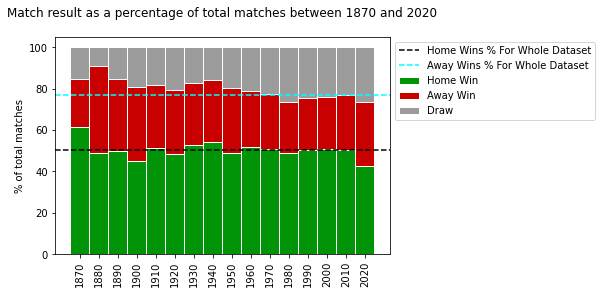

In [108]:
barWidth = 10
# Home Wins
plt.bar(x, eraHA['HWP'], color='#019409', edgecolor='white', width=barWidth, label = 'Home Win')
# Away Wins
plt.bar(x, eraHA['AWP'], bottom=eraHA['HWP'], color='#c90000', edgecolor='white', width=barWidth, label = 'Away Win')
# Draws
plt.bar(x, eraHA['DP'], bottom= eraHA['HWP'] + eraHA['AWP'], color= '#9c9c9c', edgecolor='white', width=barWidth, label = 'Draw')

plt.xticks(x, rotation = 90)

# Total Match Home Win Percentage
plt.axhline(y=TMHWPer, color = 'black', linestyle = '--', label = 'Home Wins % For Whole Dataset')

#Total Match Away Win Percentage
plt.axhline(y= (TMHWPer+TMAWPer), color = 'cyan', linestyle = '--', label = 'Away Wins % For Whole Dataset')

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

plt.title('Match result as a percentage of total matches between 1870 and 2020', pad = 20)
plt.ylabel('% of total matches')

plt.show()

The graph above shows the match outcome as a percentage of the total matches between 1870 and 2020. 

The horizontal lines both show the percentage of that match result from all the matches from the whole dataset. These are read from the bottom of the y axis up. The bottom section represents home wins, the middle section represents away wins, and the top section represents draws.

By plotting both these types of information on the same graph it is hoped this will show any deviation between the values from the whole dataset and the individual eras.

The data shows that the percentage of home wins of total matches for each of the different eras has remained relatively consistent over time.

In [109]:
eraHA['HWtoAW'] = eraHA['HWP']/eraHA['AWP']
eraHA['HWtoD'] = eraHA['HWP']/eraHA['DP']

In [110]:
eraHA

,TM,HW,AW,D,HWP,AWP,DP,HWtoAW,HWtoD
1870,13,8,3,2,61.538462,23.076923,15.384615,2.666667,4.000000
1880,55,27,23,5,49.090909,41.818182,9.090909,1.173913,5.400000
1890,58,29,20,9,50.000000,34.482759,15.517241,1.450000,3.222222
1900,124,56,44,24,45.161290,35.483871,19.354839,1.272727,2.333333
1910,268,137,82,49,51.119403,30.597015,18.283582,1.670732,2.795918
1920,687,332,213,142,48.326055,31.004367,20.669578,1.558685,2.338028
1930,896,471,271,154,52.566964,30.245536,17.187500,1.738007,3.058442
1940,638,345,191,102,54.075235,29.937304,15.987461,1.806283,3.382353
1950,1258,615,398,245,48.887122,31.637520,19.475358,1.545226,2.510204
1960,2103,1087,574,442,51.688065,27.294341,21.017594,1.893728,2.459276


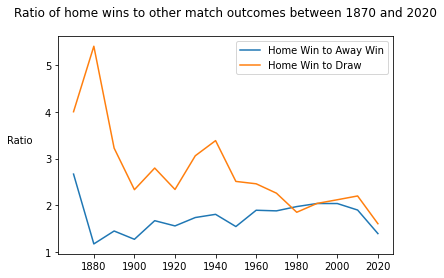

In [111]:
plt.plot(x, eraHA['HWtoAW'], label = 'Home Win to Away Win')
plt.plot(x, eraHA['HWtoD'], label = 'Home Win to Draw')

plt.ylabel('Ratio', labelpad = 25, rotation = 0)

plt.legend()

plt.title('Ratio of home wins to other match outcomes between 1870 and 2020', pad = 20)

plt.show()

The graph above shows a convergence of the ratio home wins to away wins and draws.

A. Analysis of home wins to both away wins and draws, at non neutral grounds, would suggest that for this dataset that there has been a persistent advantage for the team playing at home. 

Calculations above suggest that for the all the matches played the the home team is nearly two times more likely to record a win when compared to a loss or draw.

For each decade there was more home wins recorded compared to away wins or draws.

The amount of homewins recorded over time has remained relatively stable however there has been a convergence between away wins and draws. The data would suggest that the away team is less likely to record an away win and now has almost an equal chance of getting a draw instead.